## BrainTS2020 Dataset: Tumor Segmentation

### Imports

In [2]:
# Common Python imports
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# h5py to import h5 dataset files
import h5py

# Torch imports
import torch as th
from torch import Tensor
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
# from safetensors.torch import save_model, load_model

# Loading bar
from tqdm import trange

# Typining hints
from typing import List, Union, Callable, Tuple

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.3,
	},
)

# Hyperparameters
BATCH_TRAIN: int = 16		# Batch size for training
BATCH_VALID: int = 16			# Batch size for validation
EPOCHS: int = 1				# Number of epochs
CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
	th.nn.CrossEntropyLoss(reduction="mean")
)
EVAL_CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
	th.nn.CrossEntropyLoss(reduction="sum")
)
LR: float = 2e-3

### Dataset

##### 🔃 Loading 

In [3]:
# Directory containing .h5 files
directory = "../datasets/segmentation/data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(directory) if f.endswith('.h5')]
print(f"Found {len(h5_files)} .h5 files:\nExample file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(directory, h5_files[10060])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

Found 57195 .h5 files:
Example file names:['volume_150_slice_15.h5', 'volume_326_slice_142.h5', 'volume_220_slice_24.h5']

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 5.796816751154545
Array min val: -0.5276434702288136

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0


##### 👀 Visualization

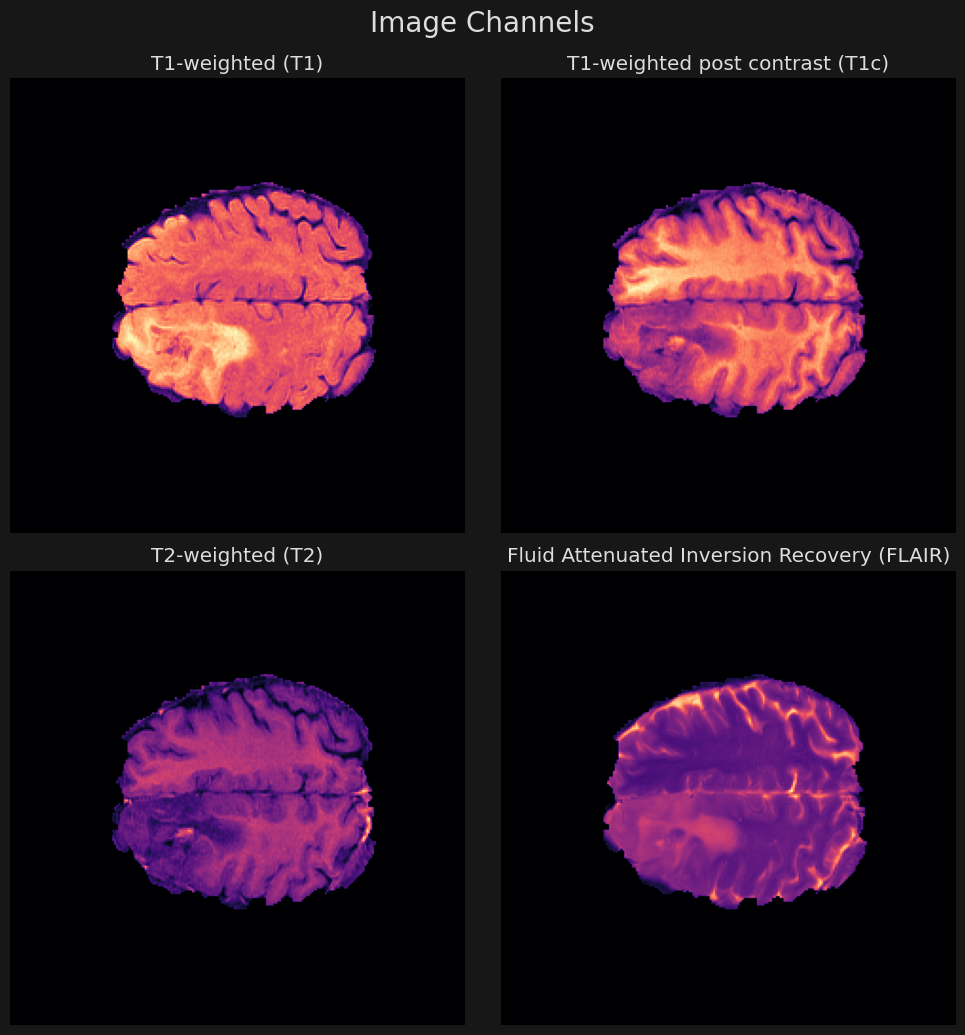

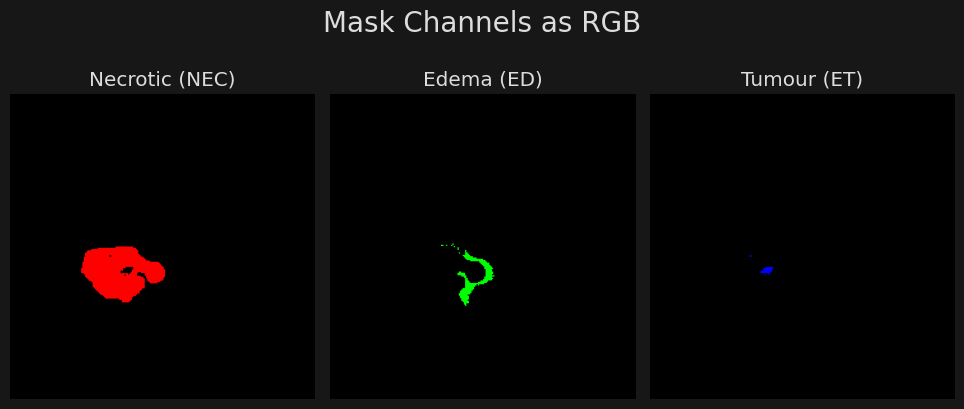

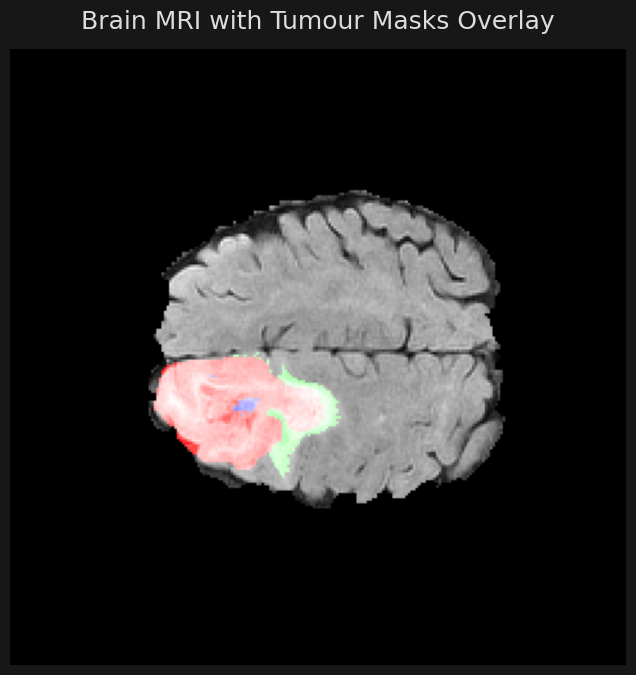

In [4]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(directory, h5_files[10060])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

##### 📊 Preprocessing: DataSet & DataLoader

In [5]:
class BrainScanDataset(Dataset):
    def __init__(self, file_paths, deterministic=False):
        self.file_paths = file_paths
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                min_val = np.min(image[i])     # Find the min value in the channel
                image[i] = image[i] - min_val  # Shift values to ensure min is 0
                max_val = np.max(image[i]) + 1e-4     # Find max value to scale max to 1 now.
                image[i] = image[i] / max_val
            
            # Convert to float and scale the whole image
            image = th.tensor(image, dtype=th.float32)
            mask = th.tensor(mask, dtype=th.float32) 
            
        return image, mask

# Build .h5 file paths from directory containing .h5 files
h5_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.9 * len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:]

# Create the train and val datasets
train_dataset = BrainScanDataset(train_files)
val_dataset = BrainScanDataset(val_files, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_TRAIN, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_VALID, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("Training batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break

Training batch - Images shape: torch.Size([16, 4, 240, 240]) Masks shape: torch.Size([16, 3, 240, 240])
Validation batch - Images shape: torch.Size([16, 4, 240, 240]) Masks shape: torch.Size([16, 3, 240, 240])


### U-Net Model

In [6]:
class EncoderBlock(th.nn.Module):
    def __init__(self, in_channels, out_channels, activation=th.nn.ReLU()):
        super().__init__()
        self.encoder_block = th.nn.Sequential(
            th.nn.Conv2d(in_channels,  out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation,
            th.nn.Conv2d(out_channels, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.encoder_block(x)
    
class DecoderBlock(th.nn.Module):
    def __init__(self, in_channels, out_channels, activation=th.nn.ReLU()):
        super().__init__()
        self.decoder_block = th.nn.Sequential(
            th.nn.Conv2d(in_channels,  in_channels//2, kernel_size=(3,3), stride=1, padding=1),
            activation,
            th.nn.Conv2d(in_channels//2, out_channels, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
    def forward(self, x):
        return self.decoder_block(x)

class UNet(th.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        n_filters    = 32  # Scaled down from 64 in original paper
        activation   = th.nn.ReLU()
        
        # Up and downsampling methods
        self.downsample  = th.nn.MaxPool2d((2,2), stride=2)
        self.upsample    = th.nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_block_1 = EncoderBlock(in_channels, 1*n_filters, activation)
        self.enc_block_2 = EncoderBlock(1*n_filters, 2*n_filters, activation)
        self.enc_block_3 = EncoderBlock(2*n_filters, 4*n_filters, activation)
        self.enc_block_4 = EncoderBlock(4*n_filters, 8*n_filters, activation)
        
        # Bottleneck
        self.bottleneck  = th.nn.Sequential(
            th.nn.Conv2d( 8*n_filters, 16*n_filters, kernel_size=(3,3), stride=1, padding=1),
            activation,
            th.nn.Conv2d(16*n_filters,  8*n_filters, kernel_size=(3,3), stride=1, padding=1),
            activation
        )
        
        # Decoder
        self.dec_block_4 = DecoderBlock(16*n_filters, 4*n_filters, activation)
        self.dec_block_3 = DecoderBlock( 8*n_filters, 2*n_filters, activation)
        self.dec_block_2 = DecoderBlock( 4*n_filters, 1*n_filters, activation)
        self.dec_block_1 = DecoderBlock( 2*n_filters, 1*n_filters, activation)
        
        # Output projection
        self.output      = th.nn.Conv2d(1*n_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)

        
    def forward(self, x):
        # Encoder
        skip_1 = self.enc_block_1(x)
        x      = self.downsample(skip_1)
        skip_2 = self.enc_block_2(x)
        x      = self.downsample(skip_2)
        skip_3 = self.enc_block_3(x)
        x      = self.downsample(skip_3)
        skip_4 = self.enc_block_4(x)
        x      = self.downsample(skip_4)
        
        # Bottleneck
        x      = self.bottleneck(x)
        
        # Decoder
        x      = self.upsample(x)
        x      = th.cat((x, skip_4), axis=1)  # Skip connection
        x      = self.dec_block_4(x)
        x      = self.upsample(x)
        x      = th.cat((x, skip_3), axis=1)  # Skip connection
        x      = self.dec_block_3(x)
        x      = self.upsample(x)
        x      = th.cat((x, skip_2), axis=1)  # Skip connection
        x      = self.dec_block_2(x)
        x      = self.upsample(x)
        x      = th.cat((x, skip_1), axis=1)  # Skip connection
        x      = self.dec_block_1(x)
        x      = self.output(x)
        return x
    
# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='model_weights.pth'):
    th.save(model.state_dict(), path)

### Training

In [6]:
def train_model(model, train_dataloader, val_dataloader, config, verbose=True):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = th.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = th.nn.BCEWithLogitsLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate * (lr_decay_factor ** (epoch - 1))
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            if verbose: print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

            if train_batch_idx >= batches_per_epoch:
                if verbose: print()
                break
        train_epoch_losses.append(train_epoch_loss)

        # Val step
        model.eval()
        val_epoch_loss = 0
        with th.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                if verbose: print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()
                
                if val_batch_idx >= batches_per_epoch:
                    if verbose: print()
                    break
        val_epoch_losses.append(val_epoch_loss)

        if verbose: print(f"Epoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")
        
    print("Training complete.")
    return train_epoch_losses, val_epoch_losses

In [7]:
# Settings for training
train_config = {
    'device': 'cuda' if th.cuda.is_available() else 'cpu',
    'n_epochs':          12,
    'batch_size':        32,
    'learning_rate':     1e-3,
    'batches_per_epoch': 50,
    'lr_decay_factor':   1
}

# Create UNet model and count params
model = UNet()
count_parameters(model)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config, verbose=False)

Total Parameters: 5,496,451

Training...


: 